![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [59]:
# Run the cells below first

In [60]:
!pip install torchmetrics
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

In [62]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [63]:
# Load Dataloader
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=False)

In [64]:
# Find the dimension of one training example 
example_image, example_label = train_data[0]
print(example_image.shape)

torch.Size([1, 28, 28])


In [65]:
# Define show image function for visualization
def imshow(img): 
    img = img / 2 + 0.5 
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

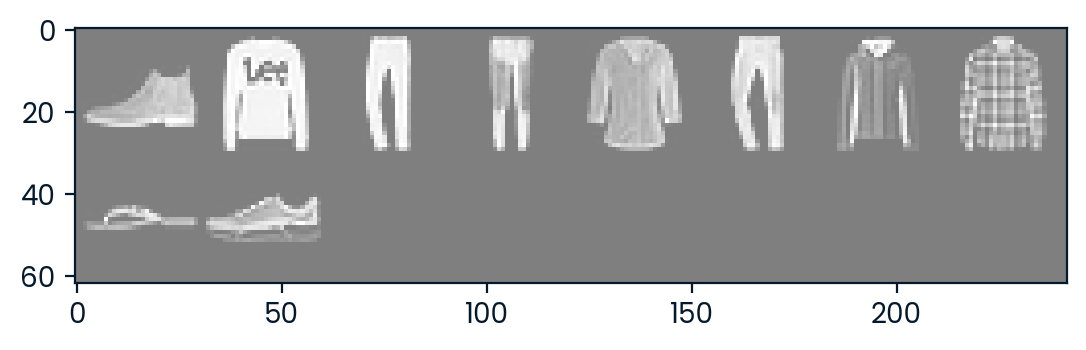

Ankle boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt Sandal Sneaker


In [66]:
from torchvision.utils import make_grid

dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Show images
imshow(make_grid(images))

# Get the class labels
classes = test_data.classes

# Print labels
print(f' '.join('%5s' % classes[labels[j]] for j in range(len(classes))))

In [67]:
# Define the model 
class Net(nn.Module): 
    def __init__(self, num_classes): 
        super().__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 2, padding = 1), # 1x28x28 -> 32x28x28
            nn.ELU(),
            nn.MaxPool2d(2), # 32x28x28 -> 32x14x14
            
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1), # 32x14x14 -> 64x14x14
            nn.ELU(),
            nn.MaxPool2d(2), # 64x7x7
            
            nn.Flatten() 
        )
        self.classifier = nn.Linear(64*7*7, num_classes)
    
    def forward(self, x): 
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [68]:
classes = test_data.classes 
num_classes = len(classes)

# Define our Model
model = Net(num_classes=num_classes)

# Define our loss function 
criterion = nn.CrossEntropyLoss() 

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [69]:
# Training loop
epochs = 2
n_total_steps = len(train_dataloader)

for epoch in range(epochs): 
    for i, (images, labels) in enumerate(train_dataloader): 
        
        # Forward pass 
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward prop 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

print('Finished Training')

Finished Training


In [70]:
# Define Metrics For all general classes
metrics_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

# Define Metrics For per-class 
metrics_precision = Precision(task="multiclass", num_classes=num_classes, average=None)
metrics_recall = Recall(task="multiclass", num_classes=num_classes, average=None)

In [71]:
# Evaluate the model 
model.eval() 
predictions = []

with torch.no_grad(): 
    for images, labels in test_dataloader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions
        predictions.extend(preds.cpu().numpy())
        
        # Update the metrics of each batch 
        metrics_accuracy(preds, labels)
        metrics_precision(preds, labels)
        metrics_recall(preds, labels)    

# Compute accuracy metric
computed_accuracy = metrics_accuracy.compute()
        
# Compute per-class metrics 
computed_precision = metrics_precision.compute()
computed_recall = metrics_recall.compute()

In [72]:
# Cast predictions into a list 
predictions = list(predictions)

# Cast accuracy into float 
accuracy = computed_accuracy.item()

# Cast precision and recall into list 
precision = computed_precision.tolist()
recall = computed_recall.tolist()

In [73]:
# Print # of predictions 
print(f"Total predictions: {len(predictions)}")

Total predictions: 10000


In [74]:
# Print Accuracy
print(f"Overall Model Accuracy: {accuracy:.2f}%") 

Overall Model Accuracy: 0.89%


In [75]:
# Print per-class precision and recall
print({
    k: computed_precision[v].item()
    for k, v in test_data.class_to_idx.items()
})

print({
    k: computed_recall[v].item()
    for k, v in test_data.class_to_idx.items()
})

{'T-shirt/top': 0.8346379399299622, 'Trouser': 0.9898887872695923, 'Pullover': 0.7237260937690735, 'Dress': 0.9278688430786133, 'Coat': 0.818652868270874, 'Sandal': 0.9907881021499634, 'Shirt': 0.7556080222129822, 'Sneaker': 0.9659936428070068, 'Bag': 0.9740518927574158, 'Ankle boot': 0.908839762210846}
{'T-shirt/top': 0.8529999852180481, 'Trouser': 0.9789999723434448, 'Pullover': 0.9089999794960022, 'Dress': 0.8489999771118164, 'Coat': 0.7900000214576721, 'Sandal': 0.9679999947547913, 'Shirt': 0.6399999856948853, 'Sneaker': 0.9089999794960022, 'Bag': 0.9760000109672546, 'Ankle boot': 0.9869999885559082}
